# Learn simple layer of LSTM


add conv layer
add l2 regularizer
add LSTMBlockFused
try LSTMcudnn
remove dropout to add optimized graph, add quantized graph

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
from saveTransformedGraph import optimizeGraph
import scipy.io.wavfile
import time
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import *




modelName = "LSTM30"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("Experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("Experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)

# directory that will contain tensorboard information
pathLog = 'Tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.8
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = 0
num_step = 150                                       # time step before reduction
conv_chan = [35]                                         #number of kernel for convolution
conv_strides = 3#int(np.ceil(num_step/num_LSTM))                  #decay between two convolution
conv_size = 12                                         #filter size for the convolution
size_poll = 4
reg_scale = 0
l1l2Prop = 0.4  # 1 =>l1, 0=> l2
reg_scale_l1 = l1l2Prop*reg_scale
reg_scale_l2 = ((1-l1l2Prop)/2)*reg_scale
num_hidden = 200                                      #num of hidden units
num_class = 1                                          #size of the output
num_feature = 1                                        # size of the input
batch_size = 2500                                   # number of sequence taken before to compute the gradient
n_layer = 1                                             #num_layer

#num_hidden = num_hidden/keep_prob
num_epoch = 100000                                      # process all the datas num_epoch times
trainDuration = 60*60*15                             # or during a determined duration(second)
                                      
amplifierName = 'MesaMarkVDisto'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat'             #dataset train/test path
fileNameTest = 'Datasets/test'+amplifierName+'.mat' # dataset validation path
fileNameValidation = 'Datasets/val'+amplifierName+'.mat'

#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain = matrix['train']
matrix = sio.loadmat(fileNameTest)
matrixTest = matrix['test']
if maxSize ==0:
    maxSize = len(matrixTrain)
    print("maxSize = {}".format(maxSize))

train_input,train_output,test_input,test_output = loadInputOutputSeq(matrixTrain,matrixTest,num_step,maxSize)


print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")
#######################
#Graph
#######################

G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data") #Number of examples, number of input step (time step), dimension of each input
        target = tf.placeholder(tf.float32, [None, num_class],name = "target") # batchSize, nbClass

    dataShaped = tf.reshape(data,[tf.shape(data)[0],num_step,1,1]) # batchSize, num_step num_feature
    with tf.variable_scope("ConvLayers"):
        regularizerC1 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC1")
        dataReduced = tf.layers.conv2d(inputs = dataShaped,filters = conv_chan[0],
                                       kernel_size = (conv_size,1),strides=(4,1),
                                       padding = "same",activation=tf.nn.elu,kernel_regularizer=regularizerC1,name="C1")#batch_size num_Lstm num_channel
        regularizerC2 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC2")
        dataReduced = tf.layers.conv2d(inputs = dataReduced,filters = conv_chan[0],
                                       kernel_size = (conv_size,1),strides=(3,1),
                                       padding = "same",activation=tf.nn.elu,kernel_regularizer=regularizerC2,name="C2")#batch_size num_Lstm num_channel
        
    dataReduced = tf.reshape(dataReduced,[tf.shape(data)[0],tf.shape(dataReduced)[1],conv_chan[0]])
    
    fusedCell = tf.contrib.rnn.LSTMBlockFusedCell(num_hidden,use_peephole=False)
 
    dataReduced = tf.transpose(dataReduced,[1,0,2])

    with tf.name_scope("extractLastValueLSTM"):
        
        val, state = fusedCell(dataReduced,dtype=tf.float32) 
        
        last_index = tf.shape(val)[0] - 1
    
        last = tf.gather(val,last_index)

    prediction = fully_connected(last,int(target.get_shape()[1]),activation_fn=tf.nn.tanh,weights_regularizer=None,scope="FCPred")
    
    #Compute the mean square error
    MSE = tf.reduce_mean(tf.square(prediction-target))
    EnergyTarget = tf.reduce_mean(tf.square(target)) 
    
    #get regularizer
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    MSEReg = tf.add_n([MSE]+reg_losses,name="MSEReg")
    # create optimizer
    optimizer = tf.train.AdamOptimizer()
    #Compute gradient and apply backpropagation
    minimize = optimizer.minimize(MSEReg)

    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    
    summary_op = tf.summary.merge_all()
    
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() # save variable, use saver.restore(sess,"date/tmp/my_model.ckpt") instead of sess.run(init_op)

##############################
# Execution du graphe
##############################
    
with tf.Session(graph=G) as sess:
    #restorePath = os.path.join('2017-09-11-18-07','temp','my_model.ckpt') # example for restore a previous model
    #saver.restore(sess,restorePath)
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')

    no_of_batches = int(np.floor((numTrain)/batch_size)) # numtrain -numstep ?
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    RMSENorm = 1
    bestRMSE = 1
    
    for epoch in range(num_epoch):
        tEpoch = time.clock()
        if (time.clock()-tStart < trainDuration) :
            ptr = 0
            if epoch % 20==0 : # each ten epoch save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'myModel.ckpt'))
            pMSETrain=0
            
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                ptr+=batch_size
                
                if j % np.floor(numTrain/len(test_input)) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str,pMSETrainTemp,pLast = sess.run([minimize,summary_op,MSE,last],{data: inp, target: out})

                    pMSETrain += pMSETrainTemp
                    step = epoch*no_of_batches+j
                    train_writer.add_summary(summary_str,step)                   

                else :
                    sess.run([minimize],{data: inp, target: out})
                    #[print(n.name) for n in tf.get_default_graph().as_graph_def().node]
                   
            RMSETrain = np.sqrt(pMSETrain/no_of_batchesTest)
            print ("Epoch -{} calculated in {:5.2f} s ".format(epoch,time.clock()-tEpoch))
            # evaluate the model on the test set (compute the mean of the MSE)
            pMSE = 0
            ptr2 = 0
            pEnergyTarget = 0
            for k in range(no_of_batchesTest):
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
            RMSETest = np.sqrt(pMSE/no_of_batchesTest)
            RMSENorm = np.sqrt(pMSE/pEnergyTarget)
            if RMSENorm<bestRMSE:
                bestRMSE=RMSENorm
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myBestGraph.pbtxt',as_text=True)
                save_path = saver.save(sess,os.path.join(pathTemp,'myBestModel.ckpt'))
            print("Epoch {}, RMSENorm: {:.5}/{:.5} on test set with deviation of {:.2f}%".format(epoch,RMSENorm,bestRMSE,100*np.sqrt((RMSETrain-RMSETest)**2)/RMSETrain))
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
    
    #######################
    # Save Graph variable and information about the running session
    #######################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pbtxt',as_text=True)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = bestRMSE
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = n_layer
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    infoLog["conv_chan"] = conv_chan
    infoLog["strides"] = conv_strides
    infoLog["conv_size"] = conv_size
    infoLog["amplifierName"]=amplifierName
    logPerf(infoLog)
    input_nodes=["placeHolder/data"]
    output_nodes=["FCPred/Tanh"]
    optimizeGraph(pathTemp,input_nodes,output_nodes)
    
    
                                                 
    
    ###############################
    #   validation dataset and emulate guitar signal
    ###############################
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['val']  
    valSize = 0
    if valSize == 0 :
        valSize = len(matrixVal)
    # shape validation test
    val_input,val_output = loadValidationSeq(matrixVal,num_step,valSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size
    #plt.show()scree
    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[:10000],label='prediction')
    ax.plot(targetArray[:10000],label='target')
    ax.legend()
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")



version 1.10.1 of tensorflow
maxSize = 6726407
shape input train (6726258, 150)
Data loaded
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


/home/totovai/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch -0 calculated in 45.79 s 
Epoch 0, RMSENorm: 0.40234/0.40234 on test set with deviation of 1.90%
Epoch -1 calculated in 45.85 s 
Epoch 1, RMSENorm: 0.37558/0.37558 on test set with deviation of 49.90%
Epoch -2 calculated in 46.14 s 
Epoch 2, RMSENorm: 0.30402/0.30402 on test set with deviation of 40.24%
Epoch -3 calculated in 46.01 s 
Epoch 3, RMSENorm: 0.28919/0.28919 on test set with deviation of 43.27%
Epoch -4 calculated in 46.02 s 
Epoch 4, RMSENorm: 0.27684/0.27684 on test set with deviation of 39.92%
Epoch -5 calculated in 46.16 s 
Epoch 5, RMSENorm: 0.27187/0.27187 on test set with deviation of 45.62%
Epoch -6 calculated in 45.97 s 
Epoch 6, RMSENorm: 0.2809/0.27187 on test set with deviation of 55.13%
Epoch -7 calculated in 45.95 s 
Epoch 7, RMSENorm: 0.27585/0.27187 on test set with deviation of 53.17%
Epoch -8 calculated in 46.01 s 
Epoch 8, RMSENorm: 0.27268/0.27187 on test set with deviation of 52.84%
Epoch -9 calculated in 46.16 s 
Epoch 9, RMSENorm: 0.27404/0.27187

Epoch -78 calculated in 45.78 s 
Epoch 78, RMSENorm: 0.21575/0.20719 on test set with deviation of 62.77%
Epoch -79 calculated in 45.94 s 
Epoch 79, RMSENorm: 0.21697/0.20719 on test set with deviation of 64.95%
Epoch -80 calculated in 46.03 s 
Epoch 80, RMSENorm: 0.22551/0.20719 on test set with deviation of 72.55%
Epoch -81 calculated in 45.80 s 
Epoch 81, RMSENorm: 0.21551/0.20719 on test set with deviation of 62.78%
Epoch -82 calculated in 46.05 s 
Epoch 82, RMSENorm: 0.22176/0.20719 on test set with deviation of 71.76%
Epoch -83 calculated in 45.84 s 
Epoch 83, RMSENorm: 0.22322/0.20719 on test set with deviation of 73.08%
Epoch -84 calculated in 46.07 s 
Epoch 84, RMSENorm: 0.21066/0.20719 on test set with deviation of 60.86%
Epoch -85 calculated in 45.98 s 
Epoch 85, RMSENorm: 0.21595/0.20719 on test set with deviation of 62.99%
Epoch -86 calculated in 45.87 s 
Epoch 86, RMSENorm: 0.2289/0.20719 on test set with deviation of 76.86%
Epoch -87 calculated in 45.90 s 
Epoch 87, RMSE

Epoch -155 calculated in 45.88 s 
Epoch 155, RMSENorm: 0.21846/0.20719 on test set with deviation of 80.22%
Epoch -156 calculated in 46.01 s 
Epoch 156, RMSENorm: 0.2136/0.20719 on test set with deviation of 77.82%
Epoch -157 calculated in 45.81 s 
Epoch 157, RMSENorm: 0.21443/0.20719 on test set with deviation of 78.61%
Epoch -158 calculated in 45.85 s 
Epoch 158, RMSENorm: 0.21447/0.20719 on test set with deviation of 75.21%
Epoch -159 calculated in 45.95 s 
Epoch 159, RMSENorm: 0.21822/0.20719 on test set with deviation of 81.79%
Epoch -160 calculated in 45.93 s 
Epoch 160, RMSENorm: 0.22461/0.20719 on test set with deviation of 86.04%
Epoch -161 calculated in 45.85 s 
Epoch 161, RMSENorm: 0.22592/0.20719 on test set with deviation of 89.63%
Epoch -162 calculated in 45.82 s 
Epoch 162, RMSENorm: 0.21399/0.20719 on test set with deviation of 78.93%
Epoch -163 calculated in 45.71 s 
Epoch 163, RMSENorm: 0.21863/0.20719 on test set with deviation of 83.88%
Epoch -164 calculated in 45.8

Epoch -231 calculated in 45.71 s 
Epoch 231, RMSENorm: 0.21458/0.20719 on test set with deviation of 84.91%
Epoch -232 calculated in 45.88 s 
Epoch 232, RMSENorm: 0.20836/0.20719 on test set with deviation of 79.84%
Epoch -233 calculated in 45.77 s 
Epoch 233, RMSENorm: 0.21171/0.20719 on test set with deviation of 86.62%
Epoch -234 calculated in 45.90 s 
Epoch 234, RMSENorm: 0.21546/0.20719 on test set with deviation of 88.62%
Epoch -235 calculated in 46.01 s 
Epoch 235, RMSENorm: 0.21354/0.20719 on test set with deviation of 83.64%
Epoch -236 calculated in 45.98 s 
Epoch 236, RMSENorm: 0.21163/0.20719 on test set with deviation of 84.62%
Epoch -237 calculated in 45.90 s 
Epoch 237, RMSENorm: 0.21813/0.20719 on test set with deviation of 91.43%
Epoch -238 calculated in 45.82 s 
Epoch 238, RMSENorm: 0.21225/0.20719 on test set with deviation of 84.21%
Epoch -239 calculated in 45.76 s 
Epoch 239, RMSENorm: 0.21339/0.20719 on test set with deviation of 83.89%
Epoch -240 calculated in 46.

Epoch -307 calculated in 45.73 s 
Epoch 307, RMSENorm: 0.20844/0.20465 on test set with deviation of 88.45%
Epoch -308 calculated in 45.74 s 
Epoch 308, RMSENorm: 0.22354/0.20465 on test set with deviation of 99.21%
Epoch -309 calculated in 45.66 s 
Epoch 309, RMSENorm: 0.21896/0.20465 on test set with deviation of 95.78%
Epoch -310 calculated in 45.85 s 
Epoch 310, RMSENorm: 0.20948/0.20465 on test set with deviation of 85.13%
Epoch -311 calculated in 45.73 s 
Epoch 311, RMSENorm: 0.21364/0.20465 on test set with deviation of 91.79%
Epoch -312 calculated in 45.86 s 
Epoch 312, RMSENorm: 0.21066/0.20465 on test set with deviation of 87.73%
Epoch -313 calculated in 45.85 s 
Epoch 313, RMSENorm: 0.20968/0.20465 on test set with deviation of 90.11%
Epoch -314 calculated in 45.77 s 
Epoch 314, RMSENorm: 0.20463/0.20463 on test set with deviation of 84.63%
Epoch -315 calculated in 45.97 s 
Epoch 315, RMSENorm: 0.21316/0.20463 on test set with deviation of 87.05%
Epoch -316 calculated in 45.

Epoch -383 calculated in 45.79 s 
Epoch 383, RMSENorm: 0.20773/0.20463 on test set with deviation of 86.02%
Epoch -384 calculated in 45.68 s 
Epoch 384, RMSENorm: 0.21233/0.20463 on test set with deviation of 89.46%
Epoch -385 calculated in 45.75 s 
Epoch 385, RMSENorm: 0.21307/0.20463 on test set with deviation of 93.41%
Epoch -386 calculated in 45.60 s 
Epoch 386, RMSENorm: 0.21511/0.20463 on test set with deviation of 95.87%
Epoch -387 calculated in 45.55 s 
Epoch 387, RMSENorm: 0.21609/0.20463 on test set with deviation of 95.82%
Epoch -388 calculated in 45.88 s 
Epoch 388, RMSENorm: 0.20864/0.20463 on test set with deviation of 88.52%
Epoch -389 calculated in 45.65 s 
Epoch 389, RMSENorm: 0.21518/0.20463 on test set with deviation of 94.10%
Epoch -390 calculated in 45.79 s 
Epoch 390, RMSENorm: 0.21578/0.20463 on test set with deviation of 95.54%
Epoch -391 calculated in 45.91 s 
Epoch 391, RMSENorm: 0.21401/0.20463 on test set with deviation of 93.10%
Epoch -392 calculated in 45.

Epoch -459 calculated in 45.78 s 
Epoch 459, RMSENorm: 0.21128/0.20463 on test set with deviation of 93.71%
Epoch -460 calculated in 46.05 s 
Epoch 460, RMSENorm: 0.21198/0.20463 on test set with deviation of 93.35%
Epoch -461 calculated in 45.66 s 
Epoch 461, RMSENorm: 0.21784/0.20463 on test set with deviation of 100.43%
Epoch -462 calculated in 45.75 s 
Epoch 462, RMSENorm: 0.22329/0.20463 on test set with deviation of 107.57%
Epoch -463 calculated in 45.60 s 
Epoch 463, RMSENorm: 0.20716/0.20463 on test set with deviation of 88.82%
Epoch -464 calculated in 45.62 s 
Epoch 464, RMSENorm: 0.21059/0.20463 on test set with deviation of 95.69%
Epoch -465 calculated in 45.78 s 
Epoch 465, RMSENorm: 0.21169/0.20463 on test set with deviation of 94.70%
Epoch -466 calculated in 45.77 s 
Epoch 466, RMSENorm: 0.21834/0.20463 on test set with deviation of 101.66%
Epoch -467 calculated in 45.80 s 
Epoch 467, RMSENorm: 0.21068/0.20463 on test set with deviation of 96.41%
Epoch -468 calculated in 

Epoch -535 calculated in 45.49 s 
Epoch 535, RMSENorm: 0.21323/0.20463 on test set with deviation of 94.58%
Epoch -536 calculated in 45.82 s 
Epoch 536, RMSENorm: 0.21472/0.20463 on test set with deviation of 96.50%
Epoch -537 calculated in 45.73 s 
Epoch 537, RMSENorm: 0.21556/0.20463 on test set with deviation of 97.72%
Epoch -538 calculated in 45.54 s 
Epoch 538, RMSENorm: 0.22404/0.20463 on test set with deviation of 109.27%
Epoch -539 calculated in 45.80 s 
Epoch 539, RMSENorm: 0.2225/0.20463 on test set with deviation of 108.28%
Epoch -540 calculated in 45.72 s 
Epoch 540, RMSENorm: 0.22292/0.20463 on test set with deviation of 108.30%
Epoch -541 calculated in 45.67 s 
Epoch 541, RMSENorm: 0.21435/0.20463 on test set with deviation of 96.42%
Epoch -542 calculated in 45.73 s 
Epoch 542, RMSENorm: 0.21225/0.20463 on test set with deviation of 98.64%
Epoch -543 calculated in 45.64 s 
Epoch 543, RMSENorm: 0.21233/0.20463 on test set with deviation of 99.73%
Epoch -544 calculated in 4

Epoch -611 calculated in 45.64 s 
Epoch 611, RMSENorm: 0.21963/0.20463 on test set with deviation of 107.11%
Epoch -612 calculated in 45.80 s 
Epoch 612, RMSENorm: 0.21686/0.20463 on test set with deviation of 105.33%
Epoch -613 calculated in 45.68 s 
Epoch 613, RMSENorm: 0.21463/0.20463 on test set with deviation of 96.90%
Epoch -614 calculated in 45.68 s 
Epoch 614, RMSENorm: 0.21568/0.20463 on test set with deviation of 101.90%
Epoch -615 calculated in 45.80 s 
Epoch 615, RMSENorm: 0.21588/0.20463 on test set with deviation of 101.80%
Epoch -616 calculated in 45.76 s 
Epoch 616, RMSENorm: 0.21934/0.20463 on test set with deviation of 105.58%
Epoch -617 calculated in 45.73 s 
Epoch 617, RMSENorm: 0.21863/0.20463 on test set with deviation of 107.91%
Epoch -618 calculated in 45.71 s 
Epoch 618, RMSENorm: 0.21961/0.20463 on test set with deviation of 106.19%
Epoch -619 calculated in 45.84 s 
Epoch 619, RMSENorm: 0.21149/0.20463 on test set with deviation of 99.62%
Epoch -620 calculated

Epoch -687 calculated in 45.80 s 
Epoch 687, RMSENorm: 0.21945/0.20463 on test set with deviation of 109.32%
Epoch -688 calculated in 45.66 s 
Epoch 688, RMSENorm: 0.21427/0.20463 on test set with deviation of 97.84%
Epoch -689 calculated in 45.79 s 
Epoch 689, RMSENorm: 0.2174/0.20463 on test set with deviation of 110.64%
Epoch -690 calculated in 45.76 s 
Epoch 690, RMSENorm: 0.21805/0.20463 on test set with deviation of 107.02%
Epoch -691 calculated in 45.66 s 
Epoch 691, RMSENorm: 0.21981/0.20463 on test set with deviation of 107.56%
Epoch -692 calculated in 45.61 s 
Epoch 692, RMSENorm: 0.21782/0.20463 on test set with deviation of 109.02%
Epoch -693 calculated in 45.60 s 
Epoch 693, RMSENorm: 0.21489/0.20463 on test set with deviation of 102.41%
Epoch -694 calculated in 45.75 s 
Epoch 694, RMSENorm: 0.21497/0.20463 on test set with deviation of 107.10%
Epoch -695 calculated in 45.58 s 
Epoch 695, RMSENorm: 0.21795/0.20463 on test set with deviation of 109.04%
Epoch -696 calculated

Epoch 762, RMSENorm: 0.221/0.20463 on test set with deviation of 109.00%
Epoch -763 calculated in 45.74 s 
Epoch 763, RMSENorm: 0.22515/0.20463 on test set with deviation of 115.12%
Epoch -764 calculated in 45.69 s 
Epoch 764, RMSENorm: 0.21843/0.20463 on test set with deviation of 106.44%
Epoch -765 calculated in 45.76 s 
Epoch 765, RMSENorm: 0.21449/0.20463 on test set with deviation of 103.94%
Epoch -766 calculated in 45.65 s 
Epoch 766, RMSENorm: 0.21435/0.20463 on test set with deviation of 105.43%
Epoch -767 calculated in 45.54 s 
Epoch 767, RMSENorm: 0.21855/0.20463 on test set with deviation of 109.02%
Epoch -768 calculated in 45.56 s 
Epoch 768, RMSENorm: 0.21636/0.20463 on test set with deviation of 107.48%
Epoch -769 calculated in 45.37 s 
Epoch 769, RMSENorm: 0.21687/0.20463 on test set with deviation of 105.17%
Epoch -770 calculated in 45.45 s 
Epoch 770, RMSENorm: 0.21639/0.20463 on test set with deviation of 105.24%
Epoch -771 calculated in 45.69 s 
Epoch 771, RMSENorm: 

Epoch -838 calculated in 45.66 s 
Epoch 838, RMSENorm: 0.22491/0.20463 on test set with deviation of 112.18%
Epoch -839 calculated in 45.75 s 
Epoch 839, RMSENorm: 0.21725/0.20463 on test set with deviation of 109.32%
Epoch -840 calculated in 45.69 s 
Epoch 840, RMSENorm: 0.21847/0.20463 on test set with deviation of 111.18%
Epoch -841 calculated in 45.68 s 
Epoch 841, RMSENorm: 0.21495/0.20463 on test set with deviation of 105.91%
Epoch -842 calculated in 45.78 s 
Epoch 842, RMSENorm: 0.21428/0.20463 on test set with deviation of 107.30%
Epoch -843 calculated in 45.64 s 
Epoch 843, RMSENorm: 0.21785/0.20463 on test set with deviation of 109.37%
Epoch -844 calculated in 45.80 s 
Epoch 844, RMSENorm: 0.21914/0.20463 on test set with deviation of 110.77%
Epoch -845 calculated in 45.61 s 
Epoch 845, RMSENorm: 0.2161/0.20463 on test set with deviation of 107.03%
Epoch -846 calculated in 45.48 s 
Epoch 846, RMSENorm: 0.21501/0.20463 on test set with deviation of 105.15%
Epoch -847 calculate

Epoch 913, RMSENorm: 0.21418/0.20463 on test set with deviation of 107.35%
Epoch -914 calculated in 45.52 s 
Epoch 914, RMSENorm: 0.21551/0.20463 on test set with deviation of 109.38%
Epoch -915 calculated in 45.70 s 
Epoch 915, RMSENorm: 0.21384/0.20463 on test set with deviation of 106.41%
Epoch -916 calculated in 45.60 s 
Epoch 916, RMSENorm: 0.21996/0.20463 on test set with deviation of 112.16%
Epoch -917 calculated in 45.65 s 
Epoch 917, RMSENorm: 0.22351/0.20463 on test set with deviation of 115.02%
Epoch -918 calculated in 45.67 s 
Epoch 918, RMSENorm: 0.22155/0.20463 on test set with deviation of 113.60%
Epoch -919 calculated in 45.58 s 
Epoch 919, RMSENorm: 0.21618/0.20463 on test set with deviation of 108.56%
Epoch -920 calculated in 45.70 s 
Epoch 920, RMSENorm: 0.21324/0.20463 on test set with deviation of 107.47%
Epoch -921 calculated in 45.70 s 
Epoch 921, RMSENorm: 0.21905/0.20463 on test set with deviation of 105.63%
Epoch -922 calculated in 45.66 s 
Epoch 922, RMSENorm

Epoch -989 calculated in 45.81 s 
Epoch 989, RMSENorm: 0.21279/0.20463 on test set with deviation of 108.21%
Epoch -990 calculated in 46.03 s 
Epoch 990, RMSENorm: 0.21256/0.20463 on test set with deviation of 102.12%
Epoch -991 calculated in 45.90 s 
Epoch 991, RMSENorm: 0.21389/0.20463 on test set with deviation of 105.30%
Epoch -992 calculated in 45.95 s 
Epoch 992, RMSENorm: 0.219/0.20463 on test set with deviation of 105.50%
Epoch -993 calculated in 45.77 s 
Epoch 993, RMSENorm: 0.21785/0.20463 on test set with deviation of 112.33%
Epoch -994 calculated in 46.03 s 
Epoch 994, RMSENorm: 0.21224/0.20463 on test set with deviation of 105.69%
Epoch -995 calculated in 45.97 s 
Epoch 995, RMSENorm: 0.21826/0.20463 on test set with deviation of 112.44%
Epoch -996 calculated in 45.87 s 
Epoch 996, RMSENorm: 0.21166/0.20463 on test set with deviation of 103.08%
Epoch -997 calculated in 46.01 s 
Epoch 997, RMSENorm: 0.21738/0.20463 on test set with deviation of 109.27%
Epoch -998 calculated

done, good job kids


<IPython.core.display.Javascript object>


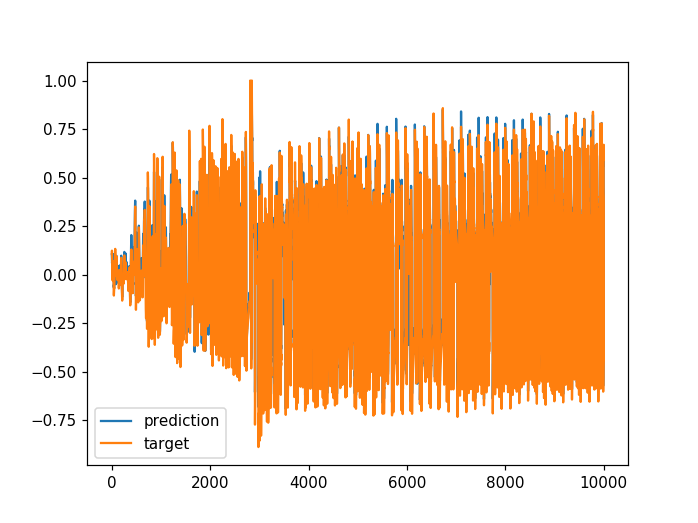

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)